In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [10]:
import gym
import gym_market
import numpy as np
import imp

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.01
take_prof_thres = 2

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [11]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 1]
Rewards: [0.44999999999999996, -4.56, -1.71, -1.86, -2.01, -1.61, -1.6300000000000001, 0.38, 1.23, -1.67, 1.31, -1.76, -1.8, 1.1600000000000001, 1.12, 3.26, 0.20999999999999996, -1.81, -1.83, 0.10000000000000003, 3.14]
Return: 1.150415831332756


In [12]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [13]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [14]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [15]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [16]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: 6.2799999999999985 Training loss: 13.0006 Explore P: 0.9979 Total return: 1.01
Episode: 2 Total reward: -45.66999999999999 Training loss: 7.2606 Explore P: 0.9959 Total return: 0.94
Episode: 3 Total reward: -13.64 Training loss: 6.5971 Explore P: 0.9938 Total return: 0.95
Episode: 4 Total reward: 9.859999999999998 Training loss: 5.9880 Explore P: 0.9917 Total return: 1.08
Episode: 5 Total reward: -4.779999999999999 Training loss: 3.0759 Explore P: 0.9897 Total return: 0.91
Episode: 6 Total reward: 4.320000000000002 Training loss: 4.4970 Explore P: 0.9876 Total return: 0.89
Episode: 7 Total reward: -38.67 Training loss: 6.8221 Explore P: 0.9856 Total return: 0.96
Episode: 8 Total reward: -29.949999999999996 Training loss: 5.0064 Explore P: 0.9835 Total return: 0.82
Episode: 9 Total reward: 5.419999999999998 Training loss: 4.6546 Explore P: 0.9815 Total return: 0.89
Episode: 10 Total reward: -1.5999999999999974 Training loss: 2.6578 Explore P: 0.9794 Total return

Episode: 84 Total reward: 3.420000000000001 Training loss: 6.2049 Explore P: 0.8399 Total return: 0.85
Episode: 85 Total reward: 17.879999999999995 Training loss: 8.3047 Explore P: 0.8382 Total return: 0.92
Episode: 86 Total reward: -7.480000000000002 Training loss: 6.5514 Explore P: 0.8364 Total return: 0.98
Episode: 87 Total reward: -3.7900000000000023 Training loss: 5.6497 Explore P: 0.8347 Total return: 0.99
Episode: 88 Total reward: -22.49 Training loss: 10.9184 Explore P: 0.8330 Total return: 1.14
Episode: 89 Total reward: -6.21 Training loss: 6.2468 Explore P: 0.8312 Total return: 0.97
Episode: 90 Total reward: 3.9099999999999997 Training loss: 6.0358 Explore P: 0.8295 Total return: 1.13
Episode: 91 Total reward: -35.56 Training loss: 4.6298 Explore P: 0.8278 Total return: 0.93
Episode: 92 Total reward: -35.220000000000006 Training loss: 5.9287 Explore P: 0.8261 Total return: 0.96
Episode: 93 Total reward: -31.039999999999992 Training loss: 7.3138 Explore P: 0.8244 Total return:

Episode: 168 Total reward: 13.299999999999999 Training loss: 5.5533 Explore P: 0.7057 Total return: 1.35
Episode: 169 Total reward: -1.629999999999999 Training loss: 5.4369 Explore P: 0.7042 Total return: 0.92
Episode: 170 Total reward: -14.47 Training loss: 4.2603 Explore P: 0.7028 Total return: 1.01
Episode: 171 Total reward: -16.669999999999998 Training loss: 3.0067 Explore P: 0.7013 Total return: 0.80
Episode: 172 Total reward: -15.570000000000007 Training loss: 3.7579 Explore P: 0.6999 Total return: 1.30
Episode: 173 Total reward: 7.389999999999996 Training loss: 8.0140 Explore P: 0.6984 Total return: 1.06
Episode: 174 Total reward: 8.079999999999998 Training loss: 3.8732 Explore P: 0.6970 Total return: 0.81
Episode: 175 Total reward: 7.29 Training loss: 6.1127 Explore P: 0.6955 Total return: 0.95
Episode: 176 Total reward: 7.76 Training loss: 6.1261 Explore P: 0.6941 Total return: 1.02
Episode: 177 Total reward: -34.64 Training loss: 5.7724 Explore P: 0.6927 Total return: 0.66
Ep

Episode: 250 Total reward: 31.44 Training loss: 8.7914 Explore P: 0.5956 Total return: 1.16
Episode: 251 Total reward: 10.45 Training loss: 6.4142 Explore P: 0.5944 Total return: 1.11
Episode: 252 Total reward: -22.5 Training loss: 5.7859 Explore P: 0.5932 Total return: 1.11
Episode: 253 Total reward: 22.810000000000002 Training loss: 8.3369 Explore P: 0.5920 Total return: 0.96
Episode: 254 Total reward: 12.590000000000003 Training loss: 6.1731 Explore P: 0.5907 Total return: 1.06
Episode: 255 Total reward: 17.589999999999996 Training loss: 7.2478 Explore P: 0.5895 Total return: 0.94
Episode: 256 Total reward: -29.819999999999997 Training loss: 5.9019 Explore P: 0.5883 Total return: 0.97
Episode: 257 Total reward: -14.840000000000002 Training loss: 4.2249 Explore P: 0.5871 Total return: 1.00
Episode: 258 Total reward: -37.26 Training loss: 3.8231 Explore P: 0.5859 Total return: 0.81
Episode: 259 Total reward: -34.589999999999996 Training loss: 7.9413 Explore P: 0.5847 Total return: 0.9

Episode: 332 Total reward: 14.070000000000006 Training loss: 4.4607 Explore P: 0.5030 Total return: 1.16
Episode: 333 Total reward: -7.110000000000003 Training loss: 4.5998 Explore P: 0.5020 Total return: 1.06
Episode: 334 Total reward: -14.83 Training loss: 6.0383 Explore P: 0.5009 Total return: 1.05
Episode: 335 Total reward: -26.439999999999998 Training loss: 8.0436 Explore P: 0.4999 Total return: 1.00
Episode: 336 Total reward: -0.6100000000000003 Training loss: 3.9416 Explore P: 0.4989 Total return: 1.00
Episode: 337 Total reward: 24.599999999999998 Training loss: 7.3784 Explore P: 0.4978 Total return: 1.06
Episode: 338 Total reward: 1.0399999999999991 Training loss: 4.5785 Explore P: 0.4968 Total return: 0.98
Episode: 339 Total reward: 9.920000000000003 Training loss: 8.3605 Explore P: 0.4958 Total return: 1.09
Episode: 340 Total reward: 4.549999999999999 Training loss: 7.3539 Explore P: 0.4948 Total return: 0.98
Episode: 341 Total reward: -38.529999999999994 Training loss: 4.039

Episode: 414 Total reward: 6.000000000000002 Training loss: 6.3532 Explore P: 0.4250 Total return: 1.02
Episode: 415 Total reward: -34.31999999999999 Training loss: 5.8164 Explore P: 0.4241 Total return: 0.81
Episode: 416 Total reward: -13.289999999999996 Training loss: 5.1657 Explore P: 0.4233 Total return: 1.11
Episode: 417 Total reward: -27.73 Training loss: 4.5661 Explore P: 0.4224 Total return: 0.97
Episode: 418 Total reward: -40.279999999999994 Training loss: 7.9749 Explore P: 0.4215 Total return: 0.73
Episode: 419 Total reward: 23.9 Training loss: 2.8502 Explore P: 0.4207 Total return: 1.16
Episode: 420 Total reward: -32.06999999999999 Training loss: 3.4498 Explore P: 0.4198 Total return: 0.98
Episode: 421 Total reward: -13.200000000000001 Training loss: 5.0687 Explore P: 0.4190 Total return: 0.99
Episode: 422 Total reward: -36.24999999999999 Training loss: 4.4058 Explore P: 0.4181 Total return: 0.94
Episode: 423 Total reward: 21.599999999999998 Training loss: 4.4333 Explore P: 

Episode: 495 Total reward: -35.22999999999999 Training loss: 4.6372 Explore P: 0.3601 Total return: 0.78
Episode: 496 Total reward: -1.5700000000000052 Training loss: 5.5305 Explore P: 0.3594 Total return: 1.08
Episode: 497 Total reward: -27.419999999999998 Training loss: 4.8094 Explore P: 0.3586 Total return: 0.96
Episode: 498 Total reward: 20.11 Training loss: 6.2619 Explore P: 0.3579 Total return: 1.10
Episode: 499 Total reward: -30.4 Training loss: 5.2506 Explore P: 0.3572 Total return: 0.95
Episode: 500 Total reward: -29.08 Training loss: 6.1671 Explore P: 0.3564 Total return: 0.95
Episode: 501 Total reward: 26.629999999999995 Training loss: 7.2021 Explore P: 0.3557 Total return: 1.17
Episode: 502 Total reward: -9.879999999999995 Training loss: 7.5443 Explore P: 0.3550 Total return: 0.88
Episode: 503 Total reward: -20.989999999999995 Training loss: 4.6027 Explore P: 0.3543 Total return: 0.88
Episode: 504 Total reward: 22.72 Training loss: 6.3161 Explore P: 0.3535 Total return: 1.1

Episode: 577 Total reward: -14.649999999999999 Training loss: 7.1861 Explore P: 0.3047 Total return: 1.00
Episode: 578 Total reward: -29.97 Training loss: 4.1332 Explore P: 0.3041 Total return: 0.93
Episode: 579 Total reward: 2.34 Training loss: 4.6159 Explore P: 0.3035 Total return: 0.97
Episode: 580 Total reward: 8.52 Training loss: 4.8846 Explore P: 0.3029 Total return: 1.36
Episode: 581 Total reward: 18.0 Training loss: 6.1486 Explore P: 0.3022 Total return: 1.11
Episode: 582 Total reward: -15.07 Training loss: 6.3787 Explore P: 0.3016 Total return: 0.97
Episode: 583 Total reward: -5.769999999999999 Training loss: 5.8237 Explore P: 0.3010 Total return: 1.03
Episode: 584 Total reward: 8.790000000000004 Training loss: 3.9791 Explore P: 0.3004 Total return: 1.14
Episode: 585 Total reward: 20.509999999999998 Training loss: 8.2521 Explore P: 0.2998 Total return: 1.04
Episode: 586 Total reward: 10.020000000000003 Training loss: 4.6759 Explore P: 0.2992 Total return: 1.04
Episode: 587 Tot

Episode: 661 Total reward: 27.039999999999996 Training loss: 6.6241 Explore P: 0.2571 Total return: 1.08
Episode: 662 Total reward: -14.349999999999996 Training loss: 5.3775 Explore P: 0.2565 Total return: 0.98
Episode: 663 Total reward: 8.24 Training loss: 4.2550 Explore P: 0.2560 Total return: 0.98
Episode: 664 Total reward: -12.700000000000005 Training loss: 6.6346 Explore P: 0.2555 Total return: 1.05
Episode: 665 Total reward: -11.359999999999998 Training loss: 2.5206 Explore P: 0.2550 Total return: 0.99
Episode: 666 Total reward: 9.05 Training loss: 7.3444 Explore P: 0.2545 Total return: 1.14
Episode: 667 Total reward: -18.27 Training loss: 5.6057 Explore P: 0.2540 Total return: 0.95
Episode: 668 Total reward: 7.749999999999999 Training loss: 4.9908 Explore P: 0.2534 Total return: 1.05
Episode: 669 Total reward: 13.860000000000001 Training loss: 3.6767 Explore P: 0.2529 Total return: 1.05
Episode: 670 Total reward: -20.97 Training loss: 3.1429 Explore P: 0.2524 Total return: 0.91


Episode: 742 Total reward: 22.709999999999997 Training loss: 6.6218 Explore P: 0.2184 Total return: 1.17
Episode: 743 Total reward: 22.060000000000002 Training loss: 4.1373 Explore P: 0.2180 Total return: 1.07
Episode: 744 Total reward: 13.629999999999999 Training loss: 4.1717 Explore P: 0.2175 Total return: 1.08
Episode: 745 Total reward: 5.239999999999999 Training loss: 2.1771 Explore P: 0.2171 Total return: 1.05
Episode: 746 Total reward: 15.239999999999998 Training loss: 2.7889 Explore P: 0.2167 Total return: 1.08
Episode: 747 Total reward: 18.79 Training loss: 4.8686 Explore P: 0.2162 Total return: 1.03
Episode: 748 Total reward: -24.33 Training loss: 3.8635 Explore P: 0.2158 Total return: 1.07
Episode: 749 Total reward: 22.080000000000002 Training loss: 4.5530 Explore P: 0.2154 Total return: 0.99
Episode: 750 Total reward: 19.710000000000004 Training loss: 5.0394 Explore P: 0.2149 Total return: 1.07
Episode: 751 Total reward: -3.480000000000002 Training loss: 1.7783 Explore P: 0.

Episode: 824 Total reward: 21.049999999999997 Training loss: 4.7400 Explore P: 0.1854 Total return: 1.43
Episode: 825 Total reward: 27.04 Training loss: 3.5837 Explore P: 0.1851 Total return: 1.19
Episode: 826 Total reward: -8.520000000000001 Training loss: 5.3413 Explore P: 0.1847 Total return: 0.99
Episode: 827 Total reward: -4.27 Training loss: 5.1984 Explore P: 0.1843 Total return: 0.89
Episode: 828 Total reward: -30.650000000000002 Training loss: 4.9290 Explore P: 0.1840 Total return: 0.97
Episode: 829 Total reward: 20.949999999999996 Training loss: 5.2051 Explore P: 0.1836 Total return: 1.02
Episode: 830 Total reward: -27.449999999999996 Training loss: 4.1628 Explore P: 0.1832 Total return: 1.09
Episode: 831 Total reward: -14.96 Training loss: 2.9636 Explore P: 0.1829 Total return: 0.99
Episode: 832 Total reward: 13.209999999999999 Training loss: 5.5053 Explore P: 0.1825 Total return: 1.14
Episode: 833 Total reward: -16.909999999999997 Training loss: 3.3480 Explore P: 0.1822 Tota

Episode: 906 Total reward: 0.9200000000000029 Training loss: 4.1349 Explore P: 0.1577 Total return: 1.12
Episode: 907 Total reward: -48.739999999999995 Training loss: 4.2981 Explore P: 0.1574 Total return: 0.82
Episode: 908 Total reward: 24.119999999999997 Training loss: 4.8056 Explore P: 0.1571 Total return: 1.17
Episode: 909 Total reward: -13.789999999999996 Training loss: 7.6102 Explore P: 0.1568 Total return: 0.87
Episode: 910 Total reward: -30.299999999999997 Training loss: 3.8466 Explore P: 0.1565 Total return: 0.97
Episode: 911 Total reward: -17.119999999999997 Training loss: 4.6161 Explore P: 0.1561 Total return: 0.91
Episode: 912 Total reward: -26.009999999999998 Training loss: 4.4904 Explore P: 0.1558 Total return: 0.94
Episode: 913 Total reward: -38.28 Training loss: 4.5610 Explore P: 0.1555 Total return: 0.97
Episode: 914 Total reward: 5.600000000000003 Training loss: 5.4058 Explore P: 0.1552 Total return: 1.07
Episode: 915 Total reward: 7.790000000000003 Training loss: 5.3

Episode: 988 Total reward: -10.550000000000004 Training loss: 3.9725 Explore P: 0.1343 Total return: 1.04
Episode: 989 Total reward: -26.119999999999997 Training loss: 6.1202 Explore P: 0.1341 Total return: 0.97
Episode: 990 Total reward: -33.00999999999999 Training loss: 4.3354 Explore P: 0.1338 Total return: 0.95
Episode: 991 Total reward: -20.659999999999997 Training loss: 3.4789 Explore P: 0.1335 Total return: 0.80
Episode: 992 Total reward: 20.410000000000004 Training loss: 4.9452 Explore P: 0.1333 Total return: 1.22
Episode: 993 Total reward: -44.56999999999999 Training loss: 5.7690 Explore P: 0.1330 Total return: 0.56
Episode: 994 Total reward: 6.15 Training loss: 2.5077 Explore P: 0.1328 Total return: 1.00
Episode: 995 Total reward: 27.440000000000005 Training loss: 5.9541 Explore P: 0.1325 Total return: 1.21
Episode: 996 Total reward: -3.159999999999999 Training loss: 2.1528 Explore P: 0.1323 Total return: 1.00
Episode: 997 Total reward: -20.849999999999998 Training loss: 6.07

Episode: 1070 Total reward: -38.96 Training loss: 4.8667 Explore P: 0.1147 Total return: 0.93
Episode: 1071 Total reward: -15.220000000000002 Training loss: 4.5362 Explore P: 0.1144 Total return: 0.99
Episode: 1072 Total reward: -47.809999999999995 Training loss: 4.4367 Explore P: 0.1142 Total return: 0.69
Episode: 1073 Total reward: 23.29 Training loss: 6.2625 Explore P: 0.1140 Total return: 1.17
Episode: 1074 Total reward: 22.669999999999995 Training loss: 3.0763 Explore P: 0.1138 Total return: 1.01
Episode: 1075 Total reward: -17.74 Training loss: 7.4962 Explore P: 0.1136 Total return: 0.99
Episode: 1076 Total reward: -15.200000000000001 Training loss: 4.5400 Explore P: 0.1133 Total return: 1.03
Episode: 1077 Total reward: -12.969999999999999 Training loss: 4.6785 Explore P: 0.1131 Total return: 0.92
Episode: 1078 Total reward: 7.999999999999998 Training loss: 3.7560 Explore P: 0.1129 Total return: 0.93
Episode: 1079 Total reward: 23.18 Training loss: 3.1369 Explore P: 0.1127 Total 

Episode: 1152 Total reward: -18.820000000000004 Training loss: 5.2225 Explore P: 0.0981 Total return: 1.03
Episode: 1153 Total reward: -12.149999999999999 Training loss: 4.1419 Explore P: 0.0979 Total return: 1.00
Episode: 1154 Total reward: 7.449999999999999 Training loss: 1.8604 Explore P: 0.0977 Total return: 1.02
Episode: 1155 Total reward: 19.049999999999997 Training loss: 3.6478 Explore P: 0.0975 Total return: 1.02
Episode: 1156 Total reward: 22.689999999999998 Training loss: 3.9917 Explore P: 0.0974 Total return: 1.01
Episode: 1157 Total reward: 3.4400000000000017 Training loss: 2.9072 Explore P: 0.0972 Total return: 1.06
Episode: 1158 Total reward: 0.3200000000000003 Training loss: 3.3274 Explore P: 0.0970 Total return: 1.01
Episode: 1159 Total reward: 22.75 Training loss: 4.0117 Explore P: 0.0968 Total return: 1.03
Episode: 1160 Total reward: -12.549999999999997 Training loss: 4.8395 Explore P: 0.0966 Total return: 0.97
Episode: 1161 Total reward: 14.08 Training loss: 3.8479 E

Episode: 1232 Total reward: 9.920000000000005 Training loss: 4.3034 Explore P: 0.0845 Total return: 1.30
Episode: 1233 Total reward: 25.45 Training loss: 4.6070 Explore P: 0.0843 Total return: 1.31
Episode: 1234 Total reward: -31.360000000000007 Training loss: 7.1530 Explore P: 0.0842 Total return: 0.84
Episode: 1235 Total reward: 25.45 Training loss: 4.2257 Explore P: 0.0840 Total return: 1.38
Episode: 1236 Total reward: -9.329999999999998 Training loss: 4.1005 Explore P: 0.0839 Total return: 0.95
Episode: 1237 Total reward: -8.680000000000003 Training loss: 3.8562 Explore P: 0.0837 Total return: 1.02
Episode: 1238 Total reward: -19.82 Training loss: 4.2362 Explore P: 0.0835 Total return: 0.96
Episode: 1239 Total reward: -34.559999999999995 Training loss: 4.7164 Explore P: 0.0834 Total return: 0.91
Episode: 1240 Total reward: 5.45 Training loss: 5.0651 Explore P: 0.0832 Total return: 1.02
Episode: 1241 Total reward: 13.449999999999998 Training loss: 4.6842 Explore P: 0.0831 Total retu

Episode: 1314 Total reward: -8.440000000000001 Training loss: 2.0893 Explore P: 0.0727 Total return: 1.07
Episode: 1315 Total reward: -10.819999999999999 Training loss: 5.7265 Explore P: 0.0726 Total return: 0.92
Episode: 1316 Total reward: -15.649999999999999 Training loss: 2.9123 Explore P: 0.0724 Total return: 0.94
Episode: 1317 Total reward: 4.4499999999999975 Training loss: 2.8115 Explore P: 0.0723 Total return: 1.32
Episode: 1318 Total reward: -18.5 Training loss: 2.6768 Explore P: 0.0722 Total return: 0.99
Episode: 1319 Total reward: 10.11 Training loss: 3.4176 Explore P: 0.0720 Total return: 1.12
Episode: 1320 Total reward: 10.449999999999998 Training loss: 3.9640 Explore P: 0.0719 Total return: 1.08
Episode: 1321 Total reward: 5.629999999999999 Training loss: 4.6168 Explore P: 0.0718 Total return: 1.33
Episode: 1322 Total reward: -10.91 Training loss: 4.9908 Explore P: 0.0717 Total return: 1.01
Episode: 1323 Total reward: -18.39 Training loss: 3.8537 Explore P: 0.0715 Total re

Episode: 1395 Total reward: 18.920000000000005 Training loss: 3.8790 Explore P: 0.0629 Total return: 1.17
Episode: 1396 Total reward: -37.41 Training loss: 4.6194 Explore P: 0.0628 Total return: 0.83
Episode: 1397 Total reward: 8.630000000000003 Training loss: 3.9296 Explore P: 0.0627 Total return: 1.04
Episode: 1398 Total reward: 16.879999999999995 Training loss: 2.9416 Explore P: 0.0626 Total return: 1.08
Episode: 1399 Total reward: -20.55 Training loss: 4.9667 Explore P: 0.0624 Total return: 0.89
Episode: 1400 Total reward: -17.929999999999996 Training loss: 6.7734 Explore P: 0.0623 Total return: 1.01
Episode: 1401 Total reward: 9.860000000000007 Training loss: 4.5925 Explore P: 0.0622 Total return: 1.01
Episode: 1402 Total reward: 23.18 Training loss: 2.9546 Explore P: 0.0621 Total return: 1.23
Episode: 1403 Total reward: -14.06 Training loss: 2.3398 Explore P: 0.0620 Total return: 1.04
Episode: 1404 Total reward: -10.529999999999998 Training loss: 3.9729 Explore P: 0.0619 Total re

Episode: 1477 Total reward: -2.85 Training loss: 6.9944 Explore P: 0.0545 Total return: 0.99
Episode: 1478 Total reward: -7.410000000000004 Training loss: 3.9771 Explore P: 0.0544 Total return: 0.97
Episode: 1479 Total reward: 4.449999999999999 Training loss: 5.0992 Explore P: 0.0543 Total return: 1.03
Episode: 1480 Total reward: -43.160000000000004 Training loss: 2.3665 Explore P: 0.0542 Total return: 0.67
Episode: 1481 Total reward: -25.150000000000002 Training loss: 4.8815 Explore P: 0.0542 Total return: 0.80
Episode: 1482 Total reward: 3.920000000000003 Training loss: 6.1441 Explore P: 0.0541 Total return: 1.08
Episode: 1483 Total reward: 13.45 Training loss: 4.2060 Explore P: 0.0540 Total return: 1.11
Episode: 1484 Total reward: 9.86 Training loss: 6.8346 Explore P: 0.0539 Total return: 1.16
Episode: 1485 Total reward: 6.149999999999999 Training loss: 5.8080 Explore P: 0.0538 Total return: 1.06
Episode: 1486 Total reward: -43.459999999999994 Training loss: 2.9860 Explore P: 0.0537

Episode: 1559 Total reward: 20.18 Training loss: 3.3999 Explore P: 0.0475 Total return: 1.25
Episode: 1560 Total reward: -0.5500000000000007 Training loss: 2.9114 Explore P: 0.0474 Total return: 1.00
Episode: 1561 Total reward: 12.05 Training loss: 3.5501 Explore P: 0.0473 Total return: 1.05
Episode: 1562 Total reward: 23.95 Training loss: 4.1216 Explore P: 0.0472 Total return: 1.27
Episode: 1563 Total reward: -32.55 Training loss: 3.6685 Explore P: 0.0472 Total return: 0.94
Episode: 1564 Total reward: -17.12 Training loss: 4.5642 Explore P: 0.0471 Total return: 0.96
Episode: 1565 Total reward: -19.32 Training loss: 5.5799 Explore P: 0.0470 Total return: 0.98
Episode: 1566 Total reward: -17.12 Training loss: 3.3858 Explore P: 0.0469 Total return: 0.98
Episode: 1567 Total reward: 20.18 Training loss: 2.7940 Explore P: 0.0469 Total return: 1.08
Episode: 1568 Total reward: -32.37 Training loss: 4.1402 Explore P: 0.0468 Total return: 0.76
Episode: 1569 Total reward: -17.12 Training loss: 2

Episode: 1641 Total reward: 16.45 Training loss: 4.1384 Explore P: 0.0416 Total return: 1.24
Episode: 1642 Total reward: 18.24 Training loss: 4.7502 Explore P: 0.0415 Total return: 1.21
Episode: 1643 Total reward: 10.209999999999999 Training loss: 2.1209 Explore P: 0.0414 Total return: 1.10
Episode: 1644 Total reward: 23.489999999999995 Training loss: 4.5246 Explore P: 0.0414 Total return: 1.37
Episode: 1645 Total reward: -29.119999999999997 Training loss: 3.3857 Explore P: 0.0413 Total return: 0.56
Episode: 1646 Total reward: -22.240000000000002 Training loss: 2.8425 Explore P: 0.0412 Total return: 0.96
Episode: 1647 Total reward: -47.11999999999999 Training loss: 3.6436 Explore P: 0.0412 Total return: 0.90
Episode: 1648 Total reward: 2.4499999999999993 Training loss: 3.5580 Explore P: 0.0411 Total return: 1.01
Episode: 1649 Total reward: 19.45 Training loss: 3.0605 Explore P: 0.0410 Total return: 1.45
Episode: 1650 Total reward: 20.209999999999997 Training loss: 3.9473 Explore P: 0.0

Episode: 1723 Total reward: -16.550000000000004 Training loss: 4.0947 Explore P: 0.0366 Total return: 1.02
Episode: 1724 Total reward: 11.96 Training loss: 6.1839 Explore P: 0.0365 Total return: 1.06
Episode: 1725 Total reward: -28.02 Training loss: 4.0444 Explore P: 0.0364 Total return: 0.96
Episode: 1726 Total reward: -40.63999999999999 Training loss: 6.2332 Explore P: 0.0364 Total return: 0.61
Episode: 1727 Total reward: -39.89000000000001 Training loss: 7.4206 Explore P: 0.0363 Total return: 0.94
Episode: 1728 Total reward: 8.979999999999997 Training loss: 2.9671 Explore P: 0.0363 Total return: 1.05
Episode: 1729 Total reward: -17.549999999999997 Training loss: 2.6296 Explore P: 0.0362 Total return: 0.97
Episode: 1730 Total reward: -9.010000000000002 Training loss: 5.4374 Explore P: 0.0362 Total return: 1.04
Episode: 1731 Total reward: 13.449999999999998 Training loss: 4.6748 Explore P: 0.0361 Total return: 1.15
Episode: 1732 Total reward: 19.45 Training loss: 3.7840 Explore P: 0.0

Episode: 1803 Total reward: 13.449999999999998 Training loss: 3.2273 Explore P: 0.0325 Total return: 1.09
Episode: 1804 Total reward: 16.45 Training loss: 5.4421 Explore P: 0.0324 Total return: 1.12
Episode: 1805 Total reward: 13.339999999999998 Training loss: 6.0943 Explore P: 0.0324 Total return: 1.02
Episode: 1806 Total reward: -43.08 Training loss: 3.4120 Explore P: 0.0323 Total return: 0.91
Episode: 1807 Total reward: -4.550000000000002 Training loss: 4.3345 Explore P: 0.0323 Total return: 1.12
Episode: 1808 Total reward: -16.009999999999994 Training loss: 4.5925 Explore P: 0.0322 Total return: 0.59
Episode: 1809 Total reward: 10.449999999999998 Training loss: 5.5944 Explore P: 0.0322 Total return: 1.07
Episode: 1810 Total reward: 25.45 Training loss: 3.3793 Explore P: 0.0321 Total return: 1.22
Episode: 1811 Total reward: 10.83 Training loss: 2.8049 Explore P: 0.0321 Total return: 1.02
Episode: 1812 Total reward: 14.0 Training loss: 2.9482 Explore P: 0.0320 Total return: 1.33
Epis

Episode: 1885 Total reward: -1.5500000000000005 Training loss: 2.8403 Explore P: 0.0289 Total return: 1.04
Episode: 1886 Total reward: 26.639999999999997 Training loss: 5.1814 Explore P: 0.0289 Total return: 1.07
Episode: 1887 Total reward: -40.41 Training loss: 4.5744 Explore P: 0.0288 Total return: 0.75
Episode: 1888 Total reward: -6.88 Training loss: 4.5269 Explore P: 0.0288 Total return: 0.91
Episode: 1889 Total reward: 2.2899999999999987 Training loss: 4.0402 Explore P: 0.0287 Total return: 1.03
Episode: 1890 Total reward: -0.5499999999999996 Training loss: 4.7452 Explore P: 0.0287 Total return: 1.00
Episode: 1891 Total reward: 20.319999999999997 Training loss: 7.5296 Explore P: 0.0287 Total return: 1.22
Episode: 1892 Total reward: 22.45 Training loss: 3.0037 Explore P: 0.0286 Total return: 1.15
Episode: 1893 Total reward: -2.0799999999999974 Training loss: 3.8465 Explore P: 0.0286 Total return: 0.87
Episode: 1894 Total reward: -52.43 Training loss: 4.6567 Explore P: 0.0285 Total 

Episode: 1967 Total reward: 4.23 Training loss: 3.7035 Explore P: 0.0259 Total return: 1.11
Episode: 1968 Total reward: 8.900000000000002 Training loss: 3.1155 Explore P: 0.0259 Total return: 1.01
Episode: 1969 Total reward: 13.429999999999998 Training loss: 4.1951 Explore P: 0.0258 Total return: 1.09
Episode: 1970 Total reward: 16.429999999999996 Training loss: 3.1730 Explore P: 0.0258 Total return: 1.07
Episode: 1971 Total reward: -10.300000000000002 Training loss: 4.1115 Explore P: 0.0258 Total return: 1.01
Episode: 1972 Total reward: -24.12 Training loss: 5.5550 Explore P: 0.0257 Total return: 0.98
Episode: 1973 Total reward: -3.1400000000000006 Training loss: 3.5279 Explore P: 0.0257 Total return: 0.99
Episode: 1974 Total reward: -9.120000000000001 Training loss: 3.3259 Explore P: 0.0257 Total return: 0.98
Episode: 1975 Total reward: -3.1499999999999977 Training loss: 4.4150 Explore P: 0.0256 Total return: 0.99
Episode: 1976 Total reward: -21.15 Training loss: 4.4657 Explore P: 0.

Episode: 2049 Total reward: -26.189999999999998 Training loss: 3.1084 Explore P: 0.0234 Total return: 0.97
Episode: 2050 Total reward: 19.859999999999996 Training loss: 3.1890 Explore P: 0.0234 Total return: 1.05
Episode: 2051 Total reward: -48.879999999999995 Training loss: 6.3572 Explore P: 0.0233 Total return: 0.70
Episode: 2052 Total reward: 22.45 Training loss: 3.9873 Explore P: 0.0233 Total return: 1.07
Episode: 2053 Total reward: 8.59 Training loss: 5.2472 Explore P: 0.0233 Total return: 0.92
Episode: 2054 Total reward: -39.74000000000001 Training loss: 5.7899 Explore P: 0.0233 Total return: 0.95
Episode: 2055 Total reward: 23.589999999999996 Training loss: 3.4435 Explore P: 0.0232 Total return: 1.13
Episode: 2056 Total reward: 13.189999999999998 Training loss: 2.7879 Explore P: 0.0232 Total return: 1.00
Episode: 2057 Total reward: -20.28 Training loss: 3.9395 Explore P: 0.0232 Total return: 1.00
Episode: 2058 Total reward: -43.41 Training loss: 2.3836 Explore P: 0.0231 Total re

Episode: 2131 Total reward: -6.800000000000001 Training loss: 2.8398 Explore P: 0.0213 Total return: 0.98
Episode: 2132 Total reward: -9.660000000000002 Training loss: 2.5791 Explore P: 0.0213 Total return: 0.98
Episode: 2133 Total reward: 16.32 Training loss: 3.4519 Explore P: 0.0212 Total return: 1.00
Episode: 2134 Total reward: -41.96 Training loss: 4.4995 Explore P: 0.0212 Total return: 0.83
Episode: 2135 Total reward: -43.709999999999994 Training loss: 2.5758 Explore P: 0.0212 Total return: 0.86
Episode: 2136 Total reward: 15.679999999999996 Training loss: 4.3263 Explore P: 0.0212 Total return: 1.00
Episode: 2137 Total reward: 16.049999999999997 Training loss: 2.8694 Explore P: 0.0211 Total return: 1.03
Episode: 2138 Total reward: -4.57 Training loss: 3.2400 Explore P: 0.0211 Total return: 1.02
Episode: 2139 Total reward: -2.169999999999997 Training loss: 4.1208 Explore P: 0.0211 Total return: 1.02
Episode: 2140 Total reward: -22.770000000000003 Training loss: 3.3601 Explore P: 0.

Episode: 2213 Total reward: 20.590000000000003 Training loss: 2.6156 Explore P: 0.0195 Total return: 1.07
Episode: 2214 Total reward: 5.28 Training loss: 5.4126 Explore P: 0.0195 Total return: 0.98
Episode: 2215 Total reward: 16.45 Training loss: 3.7887 Explore P: 0.0195 Total return: 1.60
Episode: 2216 Total reward: 12.11 Training loss: 2.8195 Explore P: 0.0194 Total return: 1.10
Episode: 2217 Total reward: -6.680000000000001 Training loss: 4.2557 Explore P: 0.0194 Total return: 0.96
Episode: 2218 Total reward: -8.41 Training loss: 4.2514 Explore P: 0.0194 Total return: 1.03
Episode: 2219 Total reward: 17.18 Training loss: 4.7687 Explore P: 0.0194 Total return: 1.08
Episode: 2220 Total reward: -31.819999999999997 Training loss: 3.4662 Explore P: 0.0194 Total return: 0.78
Episode: 2221 Total reward: 20.15 Training loss: 3.9193 Explore P: 0.0193 Total return: 1.14
Episode: 2222 Total reward: 2.979999999999999 Training loss: 2.7925 Explore P: 0.0193 Total return: 1.06
Episode: 2223 Total

Episode: 2297 Total reward: 11.25 Training loss: 5.5239 Explore P: 0.0180 Total return: 1.05
Episode: 2298 Total reward: -29.700000000000003 Training loss: 5.4202 Explore P: 0.0179 Total return: 1.25
Episode: 2299 Total reward: -14.919999999999998 Training loss: 4.0046 Explore P: 0.0179 Total return: 0.99
Episode: 2300 Total reward: -35.24 Training loss: 3.2578 Explore P: 0.0179 Total return: 0.69
Episode: 2301 Total reward: -20.369999999999994 Training loss: 2.2546 Explore P: 0.0179 Total return: 0.94
Episode: 2302 Total reward: -4.360000000000001 Training loss: 5.0264 Explore P: 0.0179 Total return: 0.96
Episode: 2303 Total reward: -1.1199999999999979 Training loss: 2.2483 Explore P: 0.0179 Total return: 1.05
Episode: 2304 Total reward: -6.5500000000000025 Training loss: 5.7899 Explore P: 0.0178 Total return: 1.00
Episode: 2305 Total reward: 28.759999999999998 Training loss: 4.2351 Explore P: 0.0178 Total return: 1.16
Episode: 2306 Total reward: 8.809999999999999 Training loss: 3.542

Episode: 2379 Total reward: -16.82 Training loss: 2.7500 Explore P: 0.0167 Total return: 0.94
Episode: 2380 Total reward: 14.449999999999998 Training loss: 4.6108 Explore P: 0.0167 Total return: 1.05
Episode: 2381 Total reward: -2.820000000000001 Training loss: 4.1941 Explore P: 0.0167 Total return: 1.01
Episode: 2382 Total reward: -23.550000000000004 Training loss: 3.2287 Explore P: 0.0167 Total return: 0.96
Episode: 2383 Total reward: 7.68 Training loss: 3.9185 Explore P: 0.0166 Total return: 1.02
Episode: 2384 Total reward: 13.249999999999996 Training loss: 2.5414 Explore P: 0.0166 Total return: 1.06
Episode: 2385 Total reward: -30.540000000000006 Training loss: 6.1154 Explore P: 0.0166 Total return: 0.92
Episode: 2386 Total reward: 4.449999999999999 Training loss: 4.7641 Explore P: 0.0166 Total return: 1.02
Episode: 2387 Total reward: 22.45 Training loss: 4.2043 Explore P: 0.0166 Total return: 1.11
Episode: 2388 Total reward: -24.65 Training loss: 3.7286 Explore P: 0.0166 Total ret

Episode: 2461 Total reward: 16.45 Training loss: 3.5731 Explore P: 0.0156 Total return: 1.16
Episode: 2462 Total reward: 1.4499999999999986 Training loss: 3.7502 Explore P: 0.0156 Total return: 1.02
Episode: 2463 Total reward: 7.4499999999999975 Training loss: 4.6974 Explore P: 0.0156 Total return: 1.04
Episode: 2464 Total reward: -38.55 Training loss: 5.0608 Explore P: 0.0156 Total return: 0.93
Episode: 2465 Total reward: -35.67 Training loss: 3.1236 Explore P: 0.0156 Total return: 0.79
Episode: 2466 Total reward: -4.320000000000001 Training loss: 2.5951 Explore P: 0.0156 Total return: 1.02
Episode: 2467 Total reward: -38.55 Training loss: 2.1708 Explore P: 0.0156 Total return: 0.72
Episode: 2468 Total reward: 2.039999999999999 Training loss: 3.5048 Explore P: 0.0156 Total return: 1.02
Episode: 2469 Total reward: -18.45 Training loss: 5.0173 Explore P: 0.0155 Total return: 0.95
Episode: 2470 Total reward: 26.38 Training loss: 4.0542 Explore P: 0.0155 Total return: 1.15
Episode: 2471 T

Episode: 2545 Total reward: 22.45 Training loss: 3.0977 Explore P: 0.0147 Total return: 1.18
Episode: 2546 Total reward: 25.45 Training loss: 2.4480 Explore P: 0.0147 Total return: 1.07
Episode: 2547 Total reward: 13.55 Training loss: 2.9451 Explore P: 0.0147 Total return: 1.04
Episode: 2548 Total reward: 13.64 Training loss: 2.5880 Explore P: 0.0147 Total return: 1.09
Episode: 2549 Total reward: -44.55 Training loss: 4.6264 Explore P: 0.0147 Total return: 0.90
Episode: 2550 Total reward: -0.3600000000000012 Training loss: 2.9918 Explore P: 0.0147 Total return: 1.02
Episode: 2551 Total reward: -28.080000000000005 Training loss: 2.1904 Explore P: 0.0147 Total return: 0.96
Episode: 2552 Total reward: -4.390000000000001 Training loss: 3.4725 Explore P: 0.0147 Total return: 1.00
Episode: 2553 Total reward: 6.3800000000000034 Training loss: 2.6289 Explore P: 0.0146 Total return: 0.99
Episode: 2554 Total reward: -13.02 Training loss: 1.8658 Explore P: 0.0146 Total return: 0.87
Episode: 2555 

Episode: 2627 Total reward: 8.95 Training loss: 2.0174 Explore P: 0.0140 Total return: 1.04
Episode: 2628 Total reward: -8.079999999999997 Training loss: 2.0648 Explore P: 0.0140 Total return: 0.76
Episode: 2629 Total reward: 4.55 Training loss: 2.2323 Explore P: 0.0140 Total return: 1.05
Episode: 2630 Total reward: 18.7 Training loss: 2.1847 Explore P: 0.0140 Total return: 1.25
Episode: 2631 Total reward: 3.3999999999999986 Training loss: 4.7053 Explore P: 0.0139 Total return: 1.08
Episode: 2632 Total reward: 1.2499999999999991 Training loss: 2.9802 Explore P: 0.0139 Total return: 1.02
Episode: 2633 Total reward: 7.4499999999999975 Training loss: 3.3310 Explore P: 0.0139 Total return: 1.17
Episode: 2634 Total reward: 16.549999999999997 Training loss: 2.9781 Explore P: 0.0139 Total return: 1.03
Episode: 2635 Total reward: -28.42 Training loss: 3.0279 Explore P: 0.0139 Total return: 0.98
Episode: 2636 Total reward: 7.45 Training loss: 3.4805 Explore P: 0.0139 Total return: 1.04
Episode:

Episode: 2709 Total reward: 7.339999999999999 Training loss: 2.5934 Explore P: 0.0133 Total return: 1.05
Episode: 2710 Total reward: 11.24 Training loss: 3.0737 Explore P: 0.0133 Total return: 1.08
Episode: 2711 Total reward: 13.499999999999996 Training loss: 2.1627 Explore P: 0.0133 Total return: 1.08
Episode: 2712 Total reward: -5.690000000000001 Training loss: 2.5953 Explore P: 0.0133 Total return: 1.09
Episode: 2713 Total reward: -4.5500000000000025 Training loss: 3.0107 Explore P: 0.0133 Total return: 1.10
Episode: 2714 Total reward: -16.71 Training loss: 4.2867 Explore P: 0.0133 Total return: 0.96
Episode: 2715 Total reward: 16.900000000000002 Training loss: 3.4499 Explore P: 0.0133 Total return: 1.03
Episode: 2716 Total reward: 5.590000000000003 Training loss: 1.8801 Explore P: 0.0133 Total return: 1.00
Episode: 2717 Total reward: 22.45 Training loss: 3.2142 Explore P: 0.0133 Total return: 1.09
Episode: 2718 Total reward: -41.12 Training loss: 3.2363 Explore P: 0.0133 Total retu

Episode: 2791 Total reward: 14.980000000000002 Training loss: 2.1004 Explore P: 0.0128 Total return: 1.21
Episode: 2792 Total reward: -14.59 Training loss: 4.0179 Explore P: 0.0128 Total return: 0.97
Episode: 2793 Total reward: 21.59 Training loss: 3.6889 Explore P: 0.0128 Total return: 1.11
Episode: 2794 Total reward: 4.51 Training loss: 2.5188 Explore P: 0.0128 Total return: 1.02
Episode: 2795 Total reward: -12.989999999999998 Training loss: 3.5014 Explore P: 0.0128 Total return: 0.93
Episode: 2796 Total reward: -10.57 Training loss: 4.0491 Explore P: 0.0128 Total return: 0.99
Episode: 2797 Total reward: 9.5 Training loss: 3.4919 Explore P: 0.0128 Total return: 1.04
Episode: 2798 Total reward: -15.45 Training loss: 3.2077 Explore P: 0.0128 Total return: 0.97
Episode: 2799 Total reward: 13.55 Training loss: 3.7985 Explore P: 0.0128 Total return: 1.10
Episode: 2800 Total reward: 1.6800000000000002 Training loss: 1.9379 Explore P: 0.0128 Total return: 1.13
Episode: 2801 Total reward: -1

Episode: 2875 Total reward: 10.549999999999999 Training loss: 5.2949 Explore P: 0.0124 Total return: 1.02
Episode: 2876 Total reward: 16.549999999999997 Training loss: 6.3506 Explore P: 0.0124 Total return: 1.10
Episode: 2877 Total reward: -36.23 Training loss: 4.2077 Explore P: 0.0124 Total return: 0.84
Episode: 2878 Total reward: 14.149999999999999 Training loss: 1.9364 Explore P: 0.0123 Total return: 1.14
Episode: 2879 Total reward: -27.450000000000003 Training loss: 2.6212 Explore P: 0.0123 Total return: 0.95
Episode: 2880 Total reward: -2.8200000000000003 Training loss: 2.1290 Explore P: 0.0123 Total return: 1.02
Episode: 2881 Total reward: -21.450000000000003 Training loss: 2.4554 Explore P: 0.0123 Total return: 0.98
Episode: 2882 Total reward: -14.749999999999998 Training loss: 2.5863 Explore P: 0.0123 Total return: 1.01
Episode: 2883 Total reward: 18.06 Training loss: 2.0612 Explore P: 0.0123 Total return: 1.02
Episode: 2884 Total reward: 10.18 Training loss: 2.0509 Explore P: 

Episode: 2957 Total reward: -33.57 Training loss: 4.7979 Explore P: 0.0120 Total return: 0.90
Episode: 2958 Total reward: 10.55 Training loss: 1.9269 Explore P: 0.0120 Total return: 1.04
Episode: 2959 Total reward: -8.979999999999995 Training loss: 2.9183 Explore P: 0.0120 Total return: 0.99
Episode: 2960 Total reward: -12.120000000000001 Training loss: 3.3472 Explore P: 0.0120 Total return: 0.93
Episode: 2961 Total reward: 23.78 Training loss: 2.8236 Explore P: 0.0120 Total return: 1.15
Episode: 2962 Total reward: -7.589999999999998 Training loss: 2.1049 Explore P: 0.0120 Total return: 1.04
Episode: 2963 Total reward: 13.249999999999998 Training loss: 2.7742 Explore P: 0.0120 Total return: 1.11
Episode: 2964 Total reward: 22.78 Training loss: 1.7733 Explore P: 0.0120 Total return: 1.29
Episode: 2965 Total reward: -10.5 Training loss: 2.0881 Explore P: 0.0120 Total return: 0.98
Episode: 2966 Total reward: 14.29 Training loss: 3.4201 Explore P: 0.0120 Total return: 1.09
Episode: 2967 To

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

<Figure size 640x480 with 1 Axes>

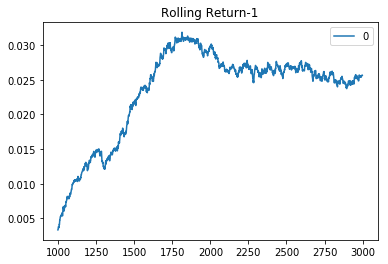

In [20]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

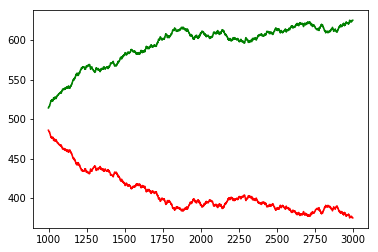

In [21]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

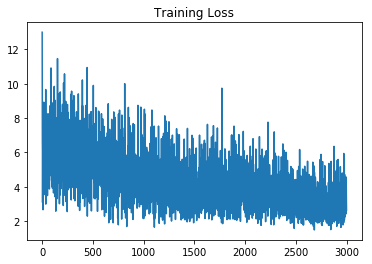

In [22]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

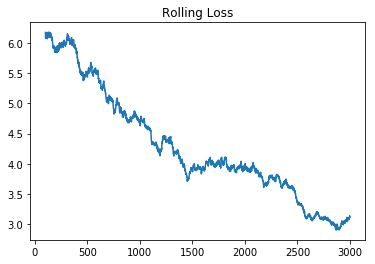

In [23]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

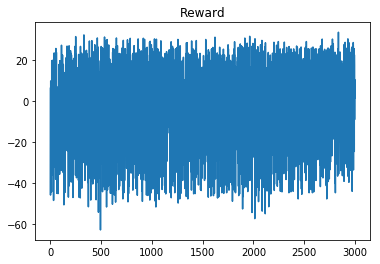

In [24]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

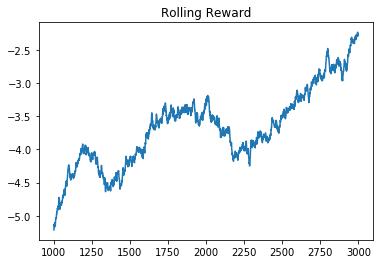

In [25]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

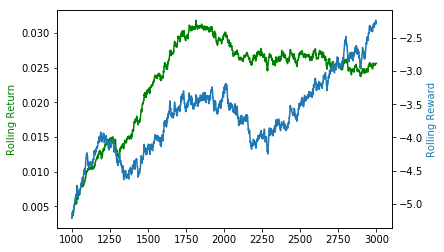

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

Run episode with trained model:

In [27]:
def run_random(prices,pos_limit,trading_freq):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        elif action*pos<0:
            trade_log.append(action*(abs(pos)+0))
            pos = 0 #action #close all existing positions and apply current action
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

In [28]:
def run_episode(env,pos_limit,trading_freq, verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    if verbose == 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
        plt.plot(plt_df.index,plt_df.Close,color='black')
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

        plt.show()
    return info_log['total_return'], random_return

Return: 1.045
Random return: 1.026


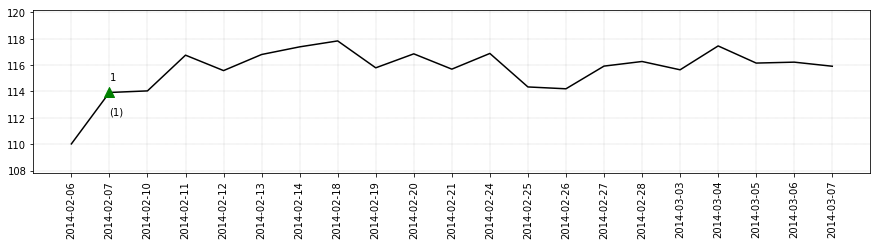

Return: 1.068
Random return: 0.963


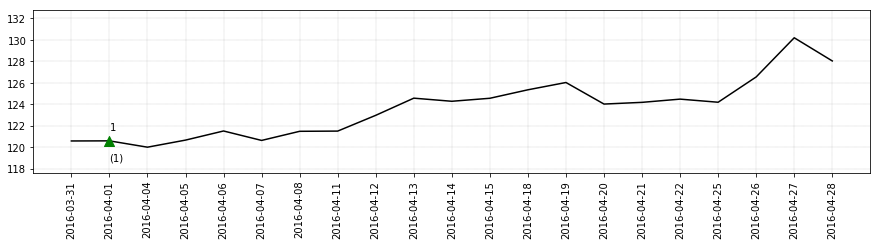

Return: 0.900
Random return: 1.171


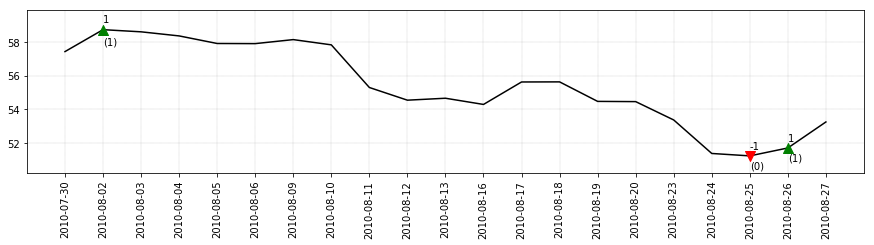

Return: 0.936
Random return: 1.025


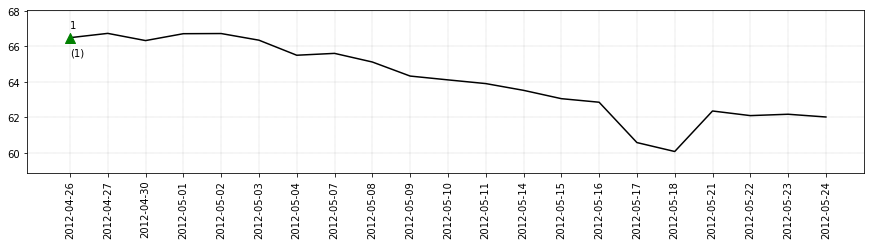

Return: 1.024
Random return: 1.059


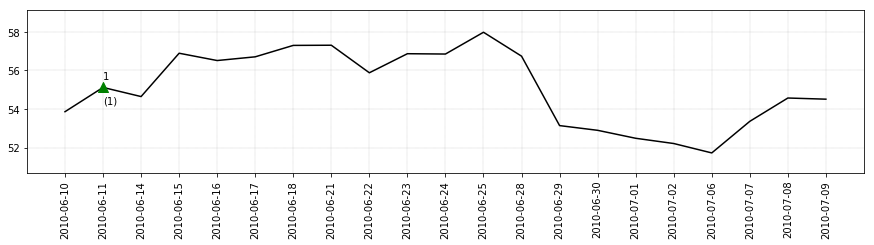

Return: 0.816
Random return: 0.711


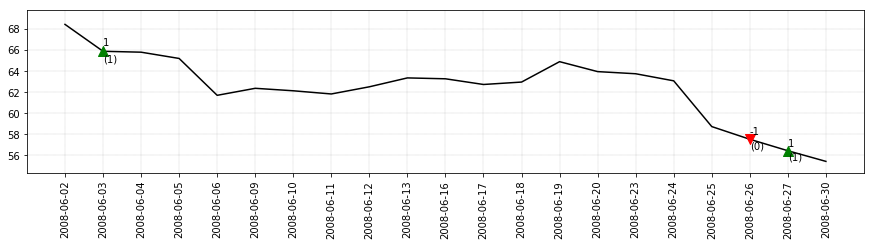

Return: 1.197
Random return: 0.892


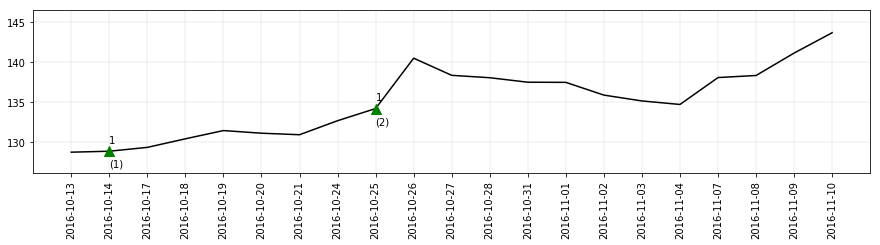

Return: 0.978
Random return: 1.013


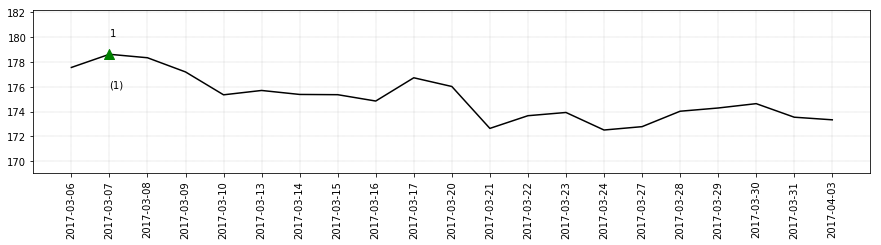

Return: 1.010
Random return: 1.014


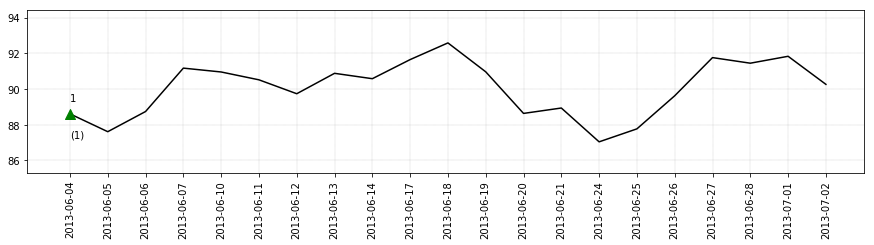

Return: 1.024
Random return: 0.924


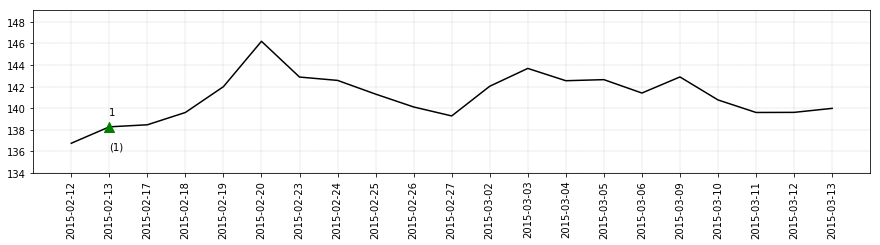

Return: 1.377
Random return: 1.045


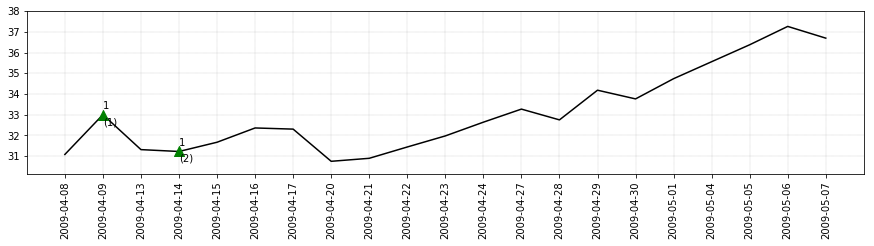

Return: 0.948
Random return: 1.010


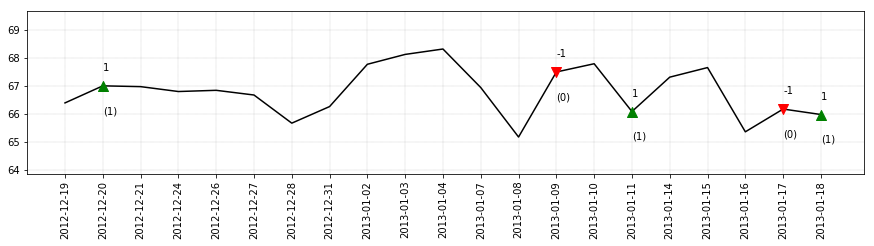

Return: 1.045
Random return: 0.980


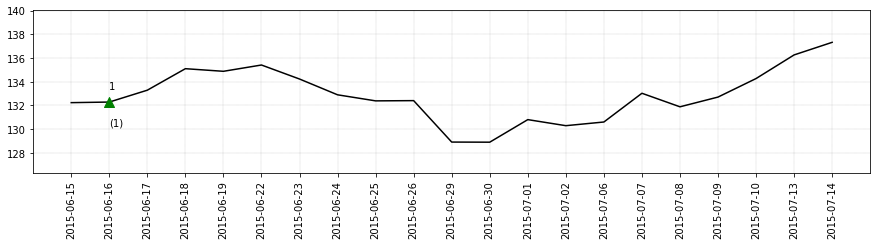

Return: 0.993
Random return: 1.003


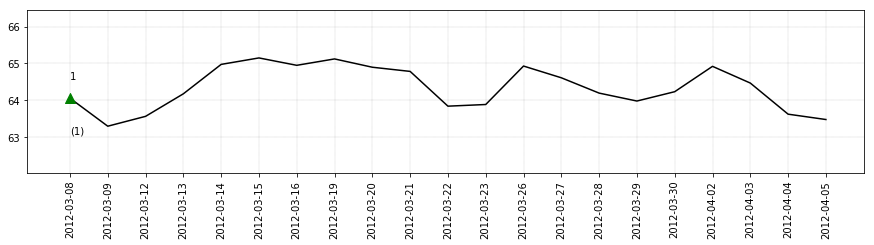

Return: 0.965
Random return: 0.783


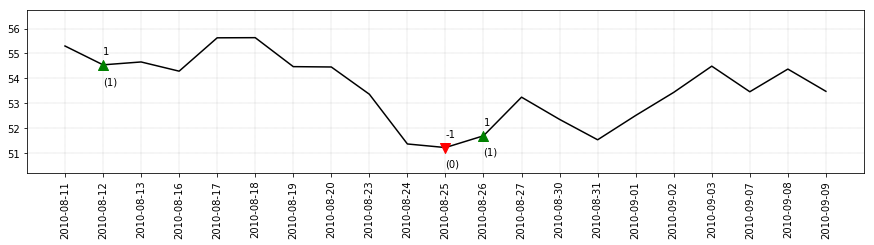

Return: 1.225
Random return: 1.178


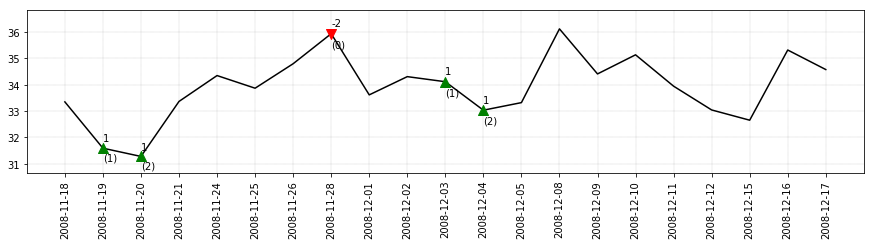

Return: 1.187
Random return: 1.096


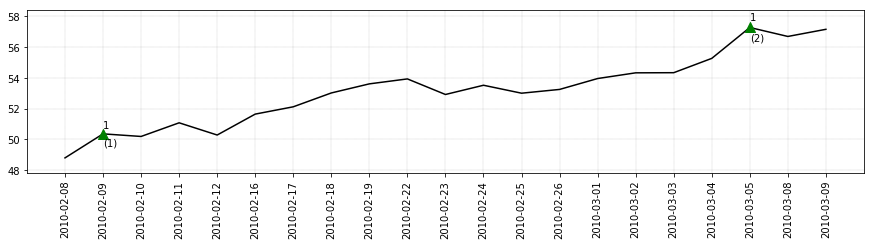

Return: 1.030
Random return: 1.074


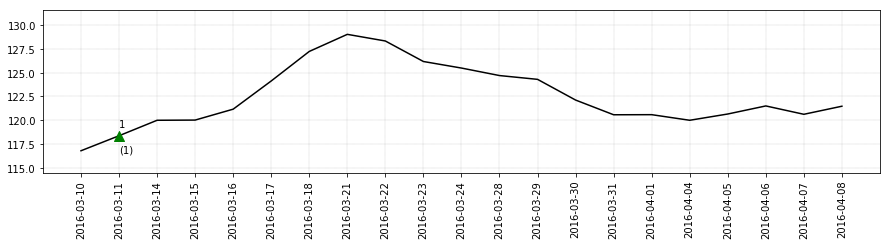

Return: 1.029
Random return: 0.989


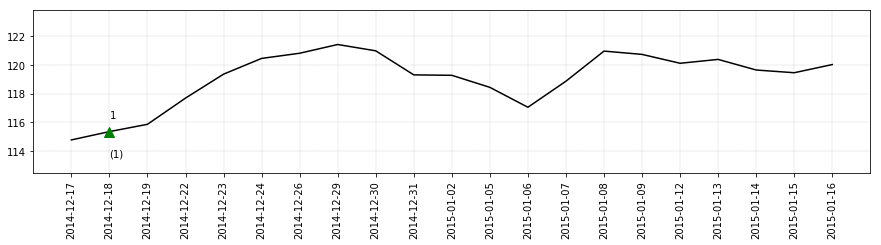

Return: 0.917
Random return: 0.955


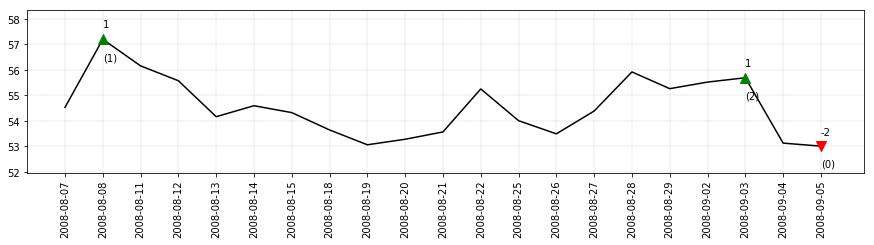

Return: 0.960
Random return: 1.142


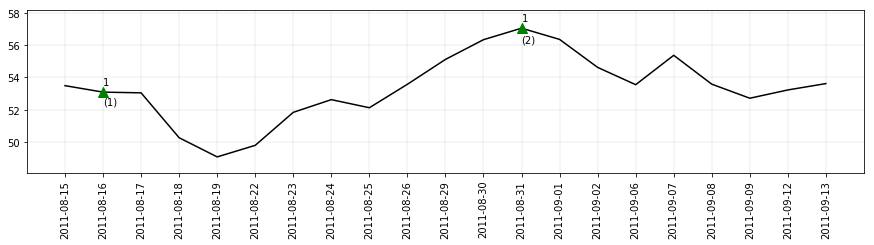

Return: 0.821
Random return: 0.803


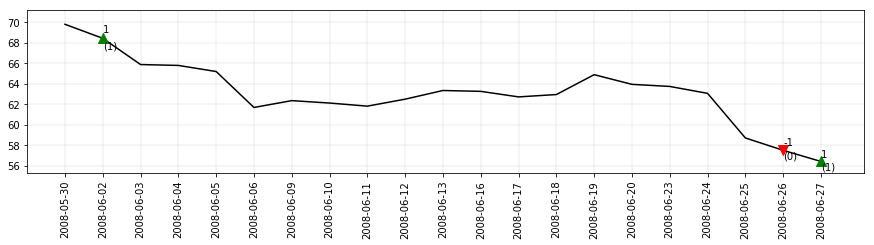

Return: 1.009
Random return: 1.062


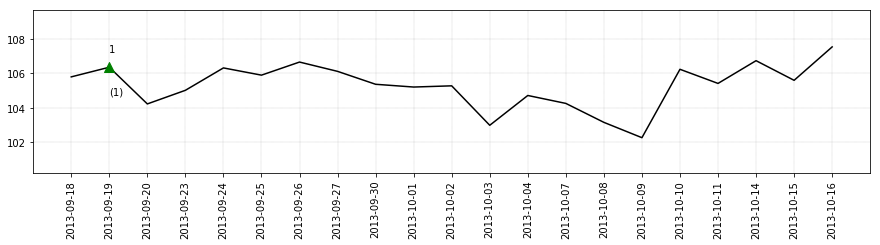

Return: 0.904
Random return: 0.997


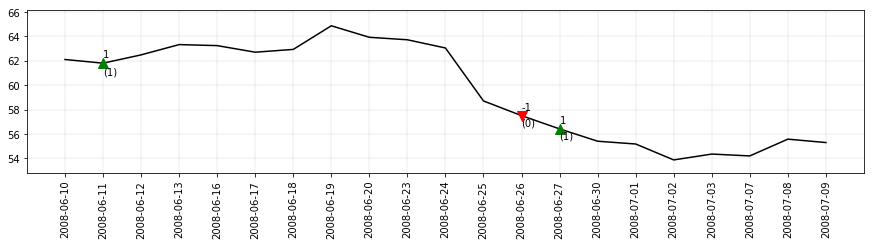

Return: 1.109
Random return: 0.806


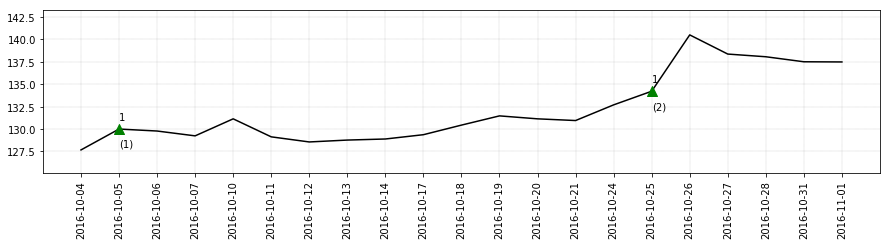

Return: 1.043
Random return: 1.126


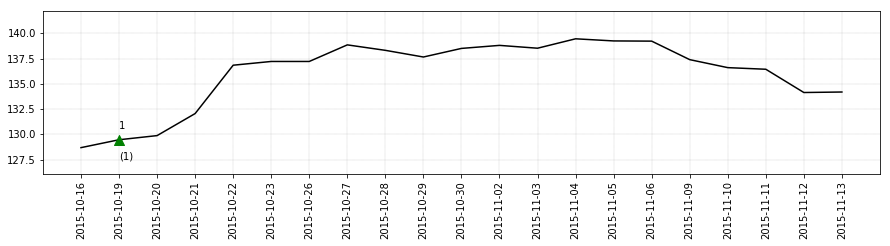

Return: 0.945
Random return: 1.008


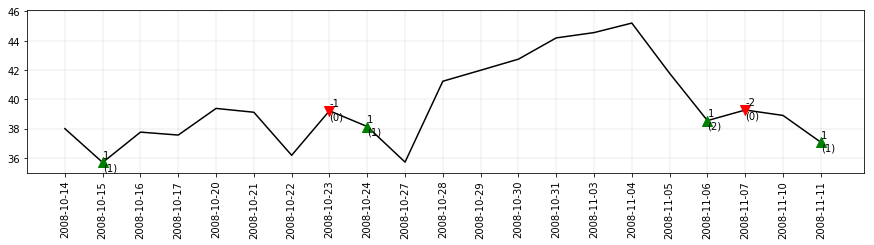

Return: 0.947
Random return: 1.057


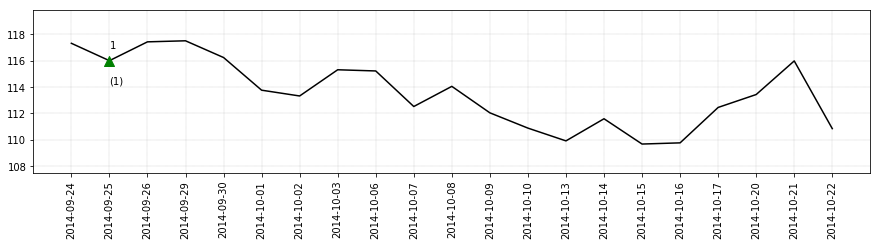

Return: 0.961
Random return: 0.947


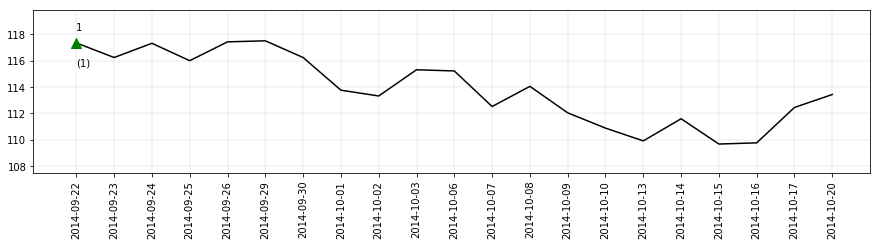

Return: 0.799
Random return: 1.011


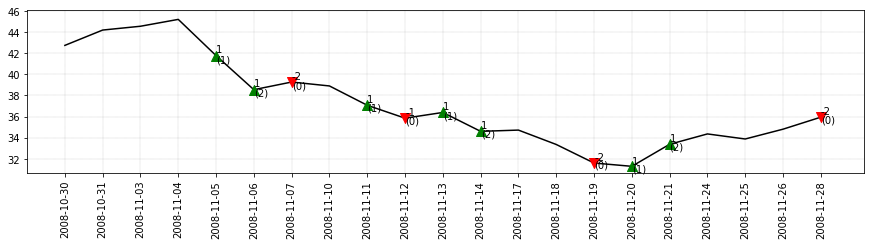

Return: 0.961
Random return: 0.989


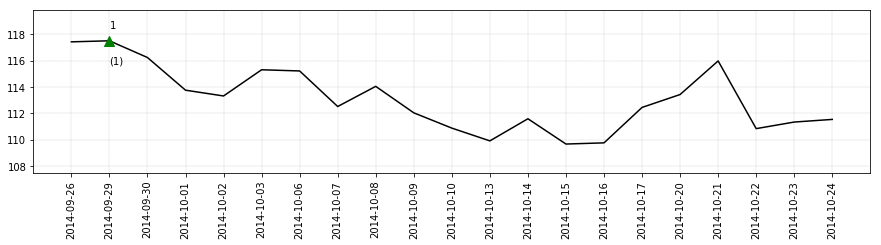

Return: 0.975
Random return: 0.982


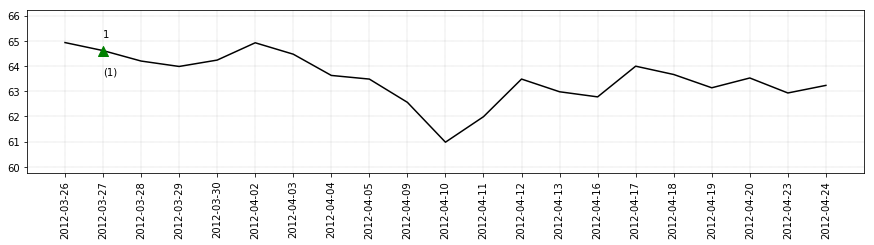

Return: 1.100
Random return: 0.920


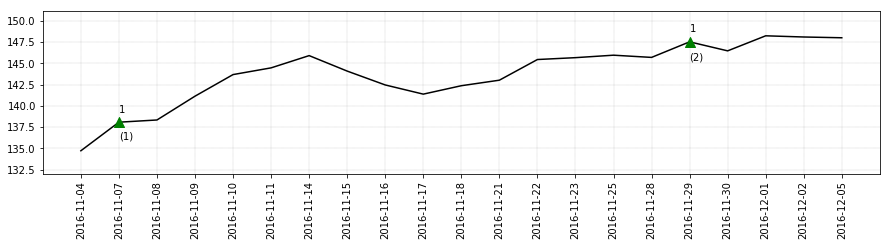

Return: 1.040
Random return: 1.072


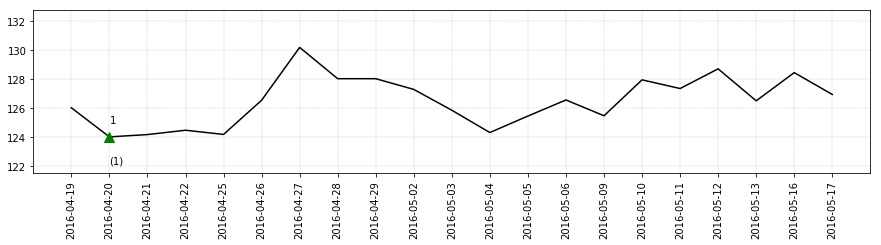

Return: 1.224
Random return: 0.787


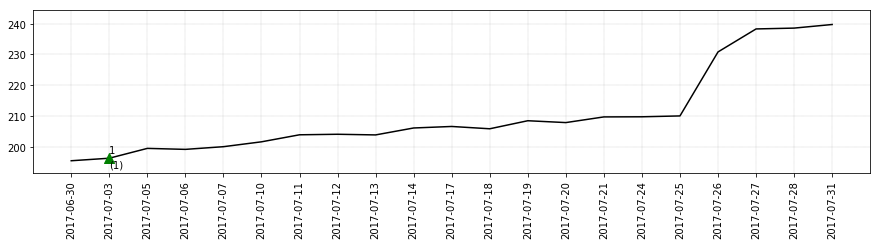

Return: 1.115
Random return: 1.090


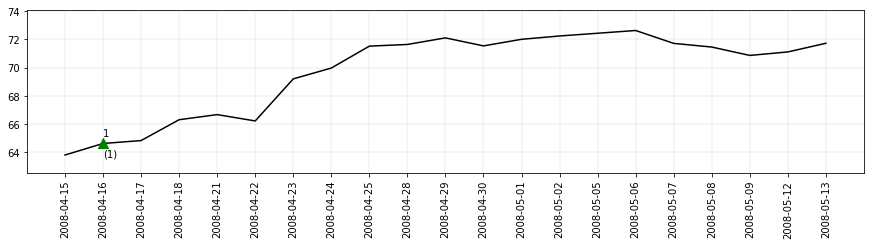

Return: 1.210
Random return: 0.993


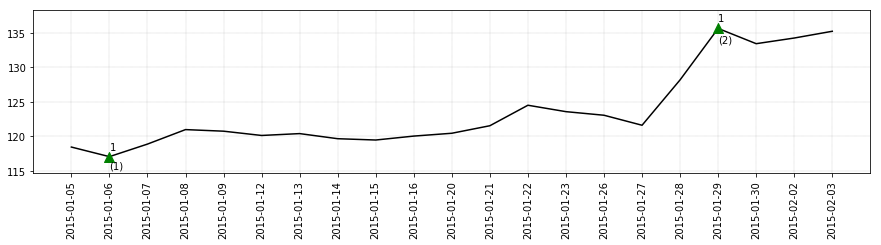

Return: 1.030
Random return: 0.948


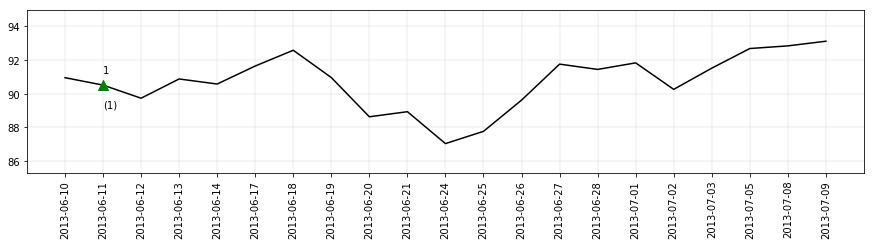

Return: 1.040
Random return: 1.008


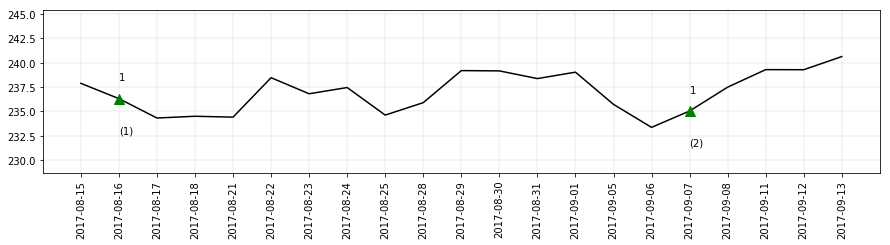

Return: 1.046
Random return: 0.854


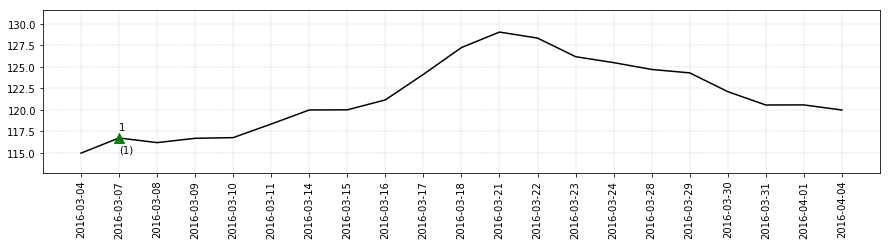

Return: 1.191
Random return: 1.083


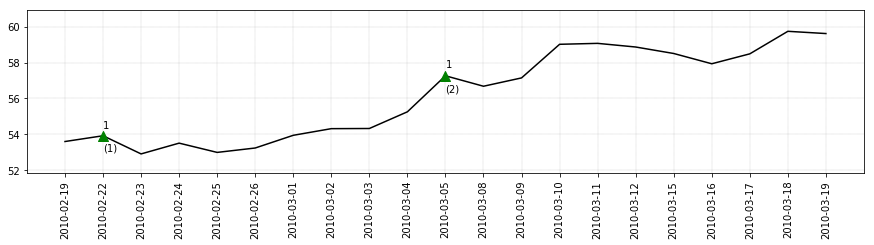

Return: 0.915
Random return: 1.048


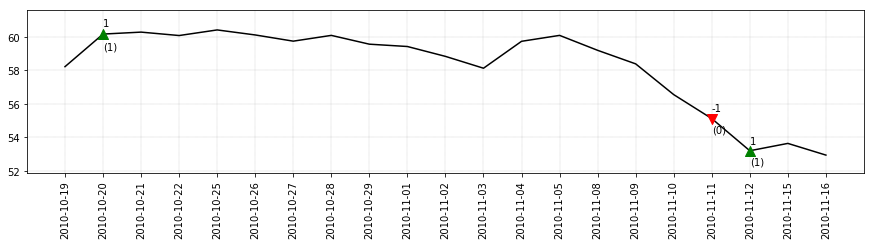

Return: 0.968
Random return: 0.949


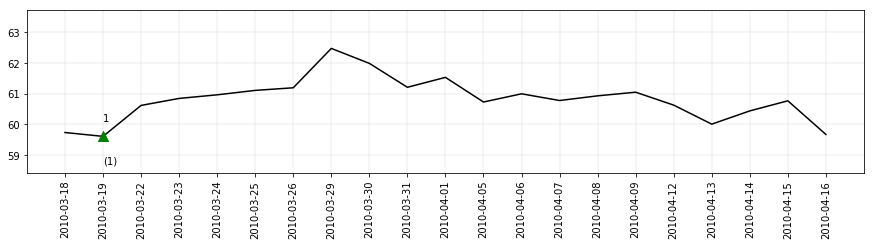

Return: 1.124
Random return: 1.071


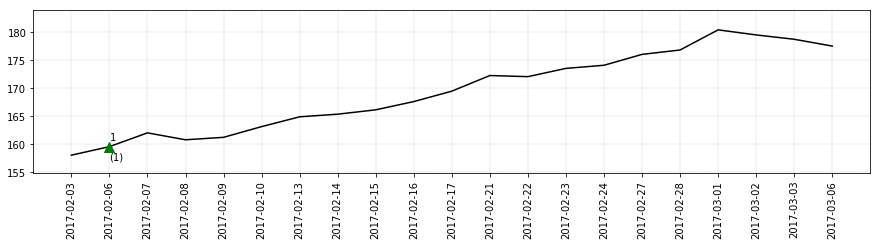

Return: 1.151
Random return: 0.953


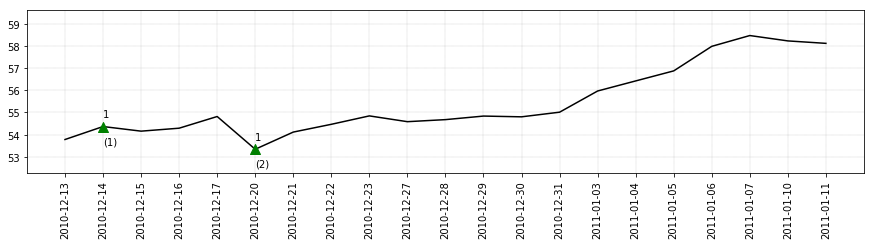

Return: 0.985
Random return: 1.014


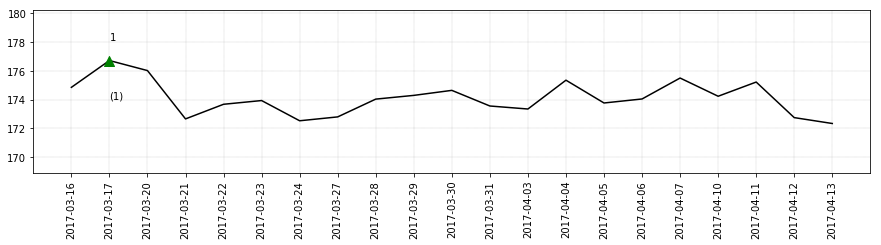

Return: 0.817
Random return: 1.004


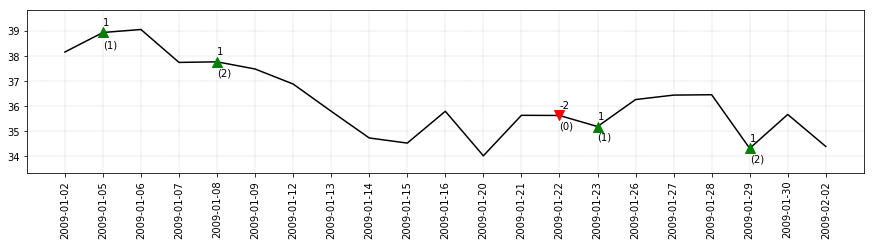

Return: 0.983
Random return: 0.926


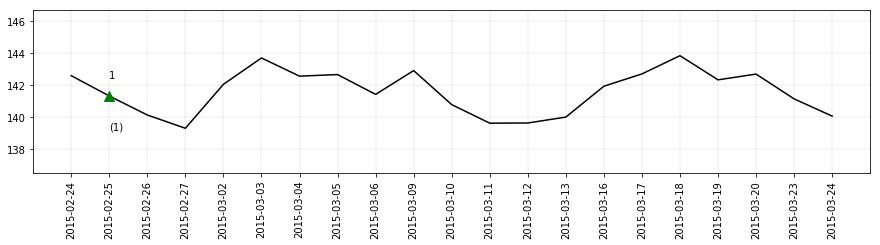

Return: 0.884
Random return: 1.011


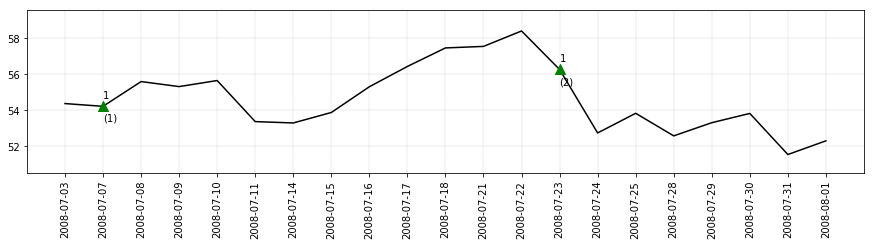

Return: 0.986
Random return: 1.001


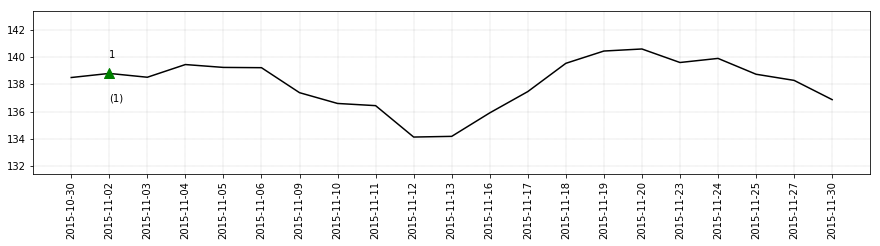

In [29]:
episode_count = 50

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq, verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [30]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (50 episodes): 1.019
Average random return (50 episodes): 0.991
